In [6]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.datasets import load_digits 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import string
import re 
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [64]:
def sigmoid(x): 
    return 1.0 / (1.0 + np.exp(-x))

def logPredict(X, w): 
    return sigmoid(np.dot(X,w))

def logAvgCost(X, y, w, regularization=None, lmda=0):
    predict = logPredict(X, w)
    cost = y * np.log(predict) + (1.0 - y) * np.log(1.0 - predict)
    cost = - cost 
    totalCost = cost.sum()
    if regularization == 'l1':
        totalCost += l1Cost(lmda, w)
    elif regularization == 'l2':
        totalCost += l2Cost(lmda, w)
    return totalCost / y.shape[0]

def l1Cost(lmda, w): 
    return lmda * np.sum(np.abs(w))

def l2Cost(lmda, w):
    return lmda * np.sum(np.square(w))

def l1Grad(lmda, w):
    gradient = lmda * np.sign(w)
    zeros = np.array(np.where(gradient == 0)).T
    for zero in zeros:
        gradient[zero] = (2.0 * np.random.rand()) - 1.0
    return gradient

def l2Grad(lmda, w): 
    return lmda * 2 * w

def logAvgGrad(X, y, w, regularization=None, lmda=0):
    predict = logPredict(X, w)
    gradient = np.dot(X.T, predict - y) 
    if regularization == 'l1':
        gradient += l1Grad(lmda, w)
    elif regularization == 'l2':
        gradient += l2Grad(lmda, w)
    return gradient / y.shape[0]

def updateWeightsGD(X, y, w, lr, regularization=None, lmda=0):
    gradient = logAvgGrad(X, y, w, regularization, lmda)
    return w - (lr * gradient)

def trainGD(X, y, lr, numIters, logFreq, regularization=None, lmda=0):
    costs = [] 
    w = np.random.rand(X.shape[1], 1)
    for i in range(numIters):
        cost = logAvgCost(X, y, w, regularization, lmda)
        w = updateWeightsGD(X, y, w, lr, regularization, lmda)
        if i % logFreq == 0: 
            print("iter:", i, "cost:", cost)
            costs.append(cost)
    return w, costs

def trainGDMulticlass(X, y, lr, numIters, logFreq, regularization=None, lmda=0):
    uniqueYs = np.unique(y)
    ys = [] 
    for uniqueY in uniqueYs: 
        binaryYs = np.copy(y)
        binaryYs += 1 
        binaryYs[binaryYs != uniqueY + 1] = 0
        binaryYs[binaryYs == uniqueY + 1] = 1
        ys.append(binaryYs)
    ys = np.array(ys)
    ws = np.random.rand(uniqueYs.shape[0],\
        X.shape[1],1)
    costs = []
    for i in range(numIters):
        cost = 0
        for uniqueY in uniqueYs: 
            cost += logAvgCost(X, ys[int(uniqueY)], ws[int(uniqueY)], regularization, lmda)
            ws[int(uniqueY)] = updateWeightsGD(X, ys[int(uniqueY)],\
                ws[int(uniqueY)], lr, regularization, lmda)
        cost /= uniqueYs.shape[0]
        if i % logFreq == 0:
            print("iter:", i, "cost:", cost)
            costs.append(cost)
    costs = np.array(costs)
    return ws, costs  

def updateWeightsAdaGrad(X, y, w, lr, S, epsilon, regularization=None, lmda=0):
    gradient = logAvgGrad(X, y, w, regularization, lmda)
    S += np.square(gradient)
    multiplier = lr / np.sqrt(S + epsilon)
    return w - np.multiply(multiplier, gradient)

def trainAdaGrad(X, y, lr, numIters, logFreq, epsilon, regularization=None, lmda=0):
    costs = [] 
    w = np.random.rand(X.shape[1], 1)
    S = np.zeros((X.shape[1], 1))
    for i in range(numIters):
        cost = logAvgCost(X, y, w, regularization, lmda)
        w = updateWeightsAdaGrad(X, y, w, lr, S, epsilon, regularization, lmda)
        if i % logFreq == 0: 
            print("iter:", i, "cost:", cost)
            costs.append(cost)
    return w, costs

def trainAdaGradMulticlass(X, y, lr, numIters, logFreq, epsilon, regularization=None, lmda=0):
    uniqueYs = np.unique(y)
    ys = [] 
    for uniqueY in uniqueYs: 
        binaryYs = np.copy(y)
        binaryYs += 1 
        binaryYs[binaryYs != uniqueY + 1] = 0
        binaryYs[binaryYs == uniqueY + 1] = 1
        ys.append(binaryYs)
    ys = np.array(ys)
    ws = np.random.rand(uniqueYs.shape[0],\
        X.shape[1],1)
    Ss = np.zeros((uniqueYs.shape[0], X.shape[1], 1))
    costs = []
    for i in range(numIters):
        cost = 0
        for uniqueY in uniqueYs: 
            cost += logAvgCost(X, ys[int(uniqueY)], ws[int(uniqueY)], regularization, lmda)
            ws[int(uniqueY)] = updateWeightsAdaGrad(X, ys[int(uniqueY)],\
                ws[int(uniqueY)], lr, Ss[int(uniqueY)], epsilon, regularization, lmda)
        cost /= uniqueYs.shape[0]
        if i % logFreq == 0:
            print("iter:", i, "cost:", cost)
            costs.append(cost)
    costs = np.array(costs)
    return ws, costs  

def logPredictMulticlass(X, w):
    predictions = [] 
    for i in range(ws.shape[0]):
        predictions.append(logPredict(X,w[i]))
    predictions = np.array(predictions)
    return np.argmax(predictions,axis=0)

def logMulticlassAccuracy(X, w, y):
    predictions = logPredictMulticlass(X, w)
    return np.sum(predictions == y) / y.shape[0]

In [24]:
# Graphing
# Graph generation method
def generateGraph(variable, trainScoresMean, testScoresMean,\
    xLabel, yLabel, title, log=False):
    plt.figure()
    if log is False:
        plt.plot(variable, trainScoresMean, "-o", color="blue",\
            label="Training Accuracy")
        plt.plot(variable, testScoresMean, "-o", color="red",\
            label="Cross-Validation Accuracy")
    else: 
        plt.semilogx(variable, trainScoresMean, "-o",\
            color="blue", label="Training Accuracy")
        plt.semilogx(variable, testScoresMean, "-o",\
            color="red", label="Cross-Validation Accuracy")
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(title)
    plt.legend(loc="lower right")

In [8]:
# MNIST
# Load dataset
digits = load_digits()
digX = digits.images 
digY = digits.target
# Reshape images into 1D vectors 
digX = np.reshape(digX, \
    (digX.shape[0], digX.shape[1] * digX.shape[2]))
# Normalize all images 
for i in range(digX.shape[0]):
    digX[i] = np.divide(digX[i], np.amax(digX,axis=1)[i])

# Split training and test sets 
digXTrain, digXTest, digYTrain, digYTest = \
    train_test_split(digX, digY, test_size=0.20)

# Ensure dimensionality matches 
digYTrain = np.expand_dims(digYTrain, axis=1)
digYTest = np.expand_dims(digYTest, axis=1)

In [9]:
# Gradient Descent Training
ws, costs = trainGDMulticlass(digXTrain,\
    digYTrain, 1, 1000, 100, 'l1', 0.1)

# Evaluation 
print("Accuracy (Training):",
    logMulticlassAccuracy(digXTrain, ws, digYTrain))
print("Accuracy (Test):",\
    logMulticlassAccuracy(digXTest, ws, digYTest))

iter: 0 cost: 9.263445981384255
iter: 100 cost: 0.08070513801186148
iter: 200 cost: 0.061903429288993325
iter: 300 cost: 0.053988872850864976
iter: 400 cost: 0.04939658933576763
iter: 500 cost: 0.04630063540942742
iter: 600 cost: 0.04402541512350163
iter: 700 cost: 0.04225931259902271
iter: 800 cost: 0.0408348384498053
iter: 900 cost: 0.03965447362558244
Accuracy (Training): 0.9756437021572721
Accuracy (Test): 0.9583333333333334


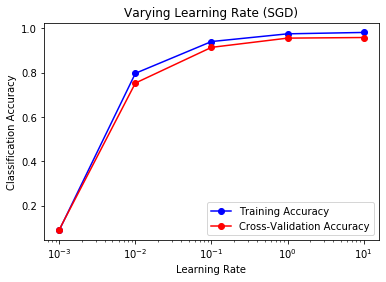

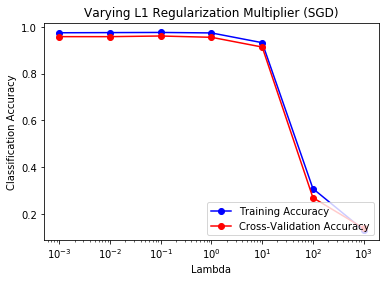

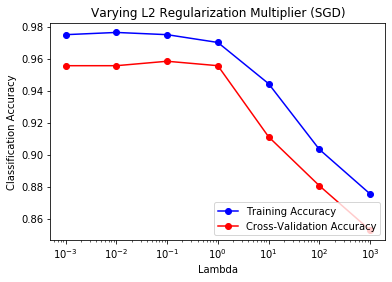

In [29]:
# Evaluation 
# Varying learning rate
# trainGDMulticlass(X, y, lr, numIters, logFreq, regularization=None, lmda=0)
lrs = np.logspace(-3,1,5)
varyLRTrainAccuracy = [] 
varyLRTestAccuracy = []
for lr in lrs: 
    # Gradient Descent Training
    ws, costs = trainGDMulticlass(digXTrain,\
        digYTrain, lr, 1000, 1000)
    # Evaluation 
    varyLRTrainAccuracy.append(logMulticlassAccuracy(digXTrain, ws, digYTrain))
    varyLRTestAccuracy.append(logMulticlassAccuracy(digXTest, ws, digYTest))

generateGraph(lrs, varyLRTrainAccuracy, varyLRTestAccuracy,\
    "Learning Rate", "Classification Accuracy", "Varying Learning Rate (SGD, MNIST)", log=True)

lmbdas = np.logspace(-3,3,7)
# Varying l1 multiplier 
varyLmbdasL1TrainAccuracy = [] 
varyLmbdasL1TestAccuracy = []
for lmbda in lmbdas: 
    # Gradient Descent Training
    ws, costs = trainGDMulticlass(digXTrain,\
        digYTrain, 1, 1000, 1000, regularization="l1", lmda=lmbda)
    # Evaluation 
    varyLmbdasL1TrainAccuracy.append(logMulticlassAccuracy(digXTrain, ws, digYTrain))
    varyLmbdasL1TestAccuracy.append(logMulticlassAccuracy(digXTest, ws, digYTest))

generateGraph(lmbdas, varyLmbdasL1TrainAccuracy, varyLmbdasL1TestAccuracy,\
    "Lambda", "Classification Accuracy", "Varying L1 Regularization Multiplier (SGD, MNIST)", log=True)

# Varying l2 multiplier 
varyLmbdasL2TrainAccuracy = [] 
varyLmbdasL2TestAccuracy = []
for lmbda in lmbdas: 
    # Gradient Descent Training
    ws, costs = trainGDMulticlass(digXTrain,\
        digYTrain, 1, 1000, 1000, regularization="l2", lmda=lmbda)
    # Evaluation 
    varyLmbdasL2TrainAccuracy.append(logMulticlassAccuracy(digXTrain, ws, digYTrain))
    varyLmbdasL2TestAccuracy.append(logMulticlassAccuracy(digXTest, ws, digYTest))

generateGraph(lmbdas, varyLmbdasL2TrainAccuracy, varyLmbdasL2TestAccuracy,\
    "Lambda", "Classification Accuracy", "Varying L2 Regularization Multiplier (SGD, MNIST)", log=True)

In [20]:
# AdaGrad Training 
ws, costs = trainAdaGradMulticlass(digXTrain,\
    digYTrain, 1, 1000, 100, 1e-8, 'l1', 0.1)

# Evaluation 
print("Accuracy (Training):",
    logMulticlassAccuracy(digXTrain, ws, digYTrain))
print("Accuracy (Test):",\
    logMulticlassAccuracy(digXTest, ws, digYTest))

iter: 0 cost: 8.881569781496816
iter: 100 cost: 0.05327439542098885
iter: 200 cost: 0.043159124027085737
iter: 300 cost: 0.03869798508779089
iter: 400 cost: 0.03605231149446609
iter: 500 cost: 0.034250503898755266
iter: 600 cost: 0.03292081115693914
iter: 700 cost: 0.03189008862229752
iter: 800 cost: 0.031062098164134817
iter: 900 cost: 0.0303797038947066
Accuracy (Training): 0.9860821155184412
Accuracy (Test): 0.9583333333333334


C:\Users\ychen\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
C:\Users\ychen\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


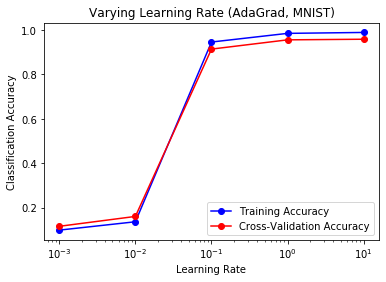

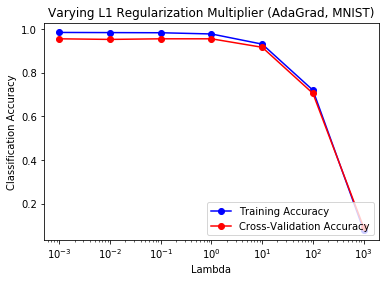

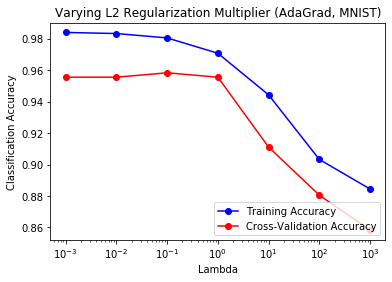

In [38]:
# Evaluation 
# Varying learning rate
lrs = np.logspace(-3,1,5)
varyLRTrainAccuracy = [] 
varyLRTestAccuracy = []
for lr in lrs: 
    # AdaGrad
    ws, costs = trainAdaGradMulticlass(digXTrain,\
        digYTrain, lr, 1000, 1000, 1e-8)
    # Evaluation 
    varyLRTrainAccuracy.append(logMulticlassAccuracy(digXTrain, ws, digYTrain))
    varyLRTestAccuracy.append(logMulticlassAccuracy(digXTest, ws, digYTest))

generateGraph(lrs, varyLRTrainAccuracy, varyLRTestAccuracy,\
    "Learning Rate", "Classification Accuracy", "Varying Learning Rate (AdaGrad, MNIST)", log=True)

lmbdas = np.logspace(-3,3,7)
# Varying l1 multiplier 
varyLmbdasL1TrainAccuracy = [] 
varyLmbdasL1TestAccuracy = []
for lmbda in lmbdas: 
    # AdaGrad
    ws, costs = trainAdaGradMulticlass(digXTrain,\
        digYTrain, 1, 1000, 1000, 1e-8, regularization="l1", lmda=lmbda)
    # Evaluation 
    varyLmbdasL1TrainAccuracy.append(logMulticlassAccuracy(digXTrain, ws, digYTrain))
    varyLmbdasL1TestAccuracy.append(logMulticlassAccuracy(digXTest, ws, digYTest))

generateGraph(lmbdas, varyLmbdasL1TrainAccuracy, varyLmbdasL1TestAccuracy,\
    "Lambda", "Classification Accuracy", "Varying L1 Regularization Multiplier (AdaGrad, MNIST)", log=True)

# Varying l2 multiplier 
varyLmbdasL2TrainAccuracy = [] 
varyLmbdasL2TestAccuracy = []
for lmbda in lmbdas: 
    # AdaGrad
    ws, costs = trainAdaGradMulticlass(digXTrain,\
        digYTrain, 1, 1000, 1000, 1e-8, regularization="l2", lmda=lmbda)
    # Evaluation 
    varyLmbdasL2TrainAccuracy.append(logMulticlassAccuracy(digXTrain, ws, digYTrain))
    varyLmbdasL2TestAccuracy.append(logMulticlassAccuracy(digXTest, ws, digYTest))

generateGraph(lmbdas, varyLmbdasL2TrainAccuracy, varyLmbdasL2TestAccuracy,\
    "Lambda", "Classification Accuracy", "Varying L2 Regularization Multiplier (AdaGrad, MNIST)", log=True)

In [40]:
# Sentiment classification  
# on the Twitter US Airline Sentiment Dataset 
tweets = pd.read_csv('./Tweets.csv', sep=',')

# Process labels 
textYRaw = np.array(tweets['airline_sentiment'])
textY = np.zeros(textYRaw.shape)
# Convert y categories into numerical values 
textY[textYRaw == 'negative'] = 0 
textY[textYRaw == 'neutral'] = 1
textY[textYRaw == 'positive'] = 2
textY = np.expand_dims(textY, axis=1)

# Clean text 
textXRaw = tweets['text'].tolist()
textXCleaned = []
for i in range(len(textXRaw)):
    rawText = textXRaw[i]
    # Set all lower case
    processed = rawText.lower()
    # Remove twitter tags 
    processed = " ".join(filter(lambda x:x[0] !='@', processed.split()))
    # Remove numbers 
    processed = re.sub(r'\d+','',processed)
    # Remove punctuation
    processed = processed.translate(str.maketrans("","", string.punctuation))
    # Remove whitespaces 
    processed = processed.strip()
    textXCleaned.append(processed)

# Split into training and test sets 
# Split training and test sets 
textXTrainText, textXTestText, textYTrain, textYTest = \
    train_test_split(textXCleaned, textY, test_size=0.20)

# Use the top 500 most frequently appearing 
# words for classification
# Bag of words approach: 
vectorizer = CountVectorizer(max_features=500)
textXTrainCounts = vectorizer.fit_transform(textXTrainText)
# tf-idf: term frequency-inverse document frequency 
tfTransformer = TfidfTransformer()
textXTrain = tfTransformer.fit_transform(textXTrainCounts)
textXTrain = textXTrain.toarray()
textXTestCounts = vectorizer.transform(textXTestText)
textXTest = tfTransformer.fit_transform(textXTestCounts)
textXTest = textXTest.toarray()

# textXTrain, textYTrain, textXTest, textYTest

# Our method of vectorizing text input from scratch
# Assume cleaned input (no punctuation, same case, etc.)
def vectorizeText(XCleaned):
    # Tokenize text 
    XTokenized = [] 
    stopWords = stopwords.words('english')
    wordnetLemmatizer = WordNetLemmatizer()
    for i in range(len(XCleaned)):
        tokens = nltk.word_tokenize(XCleaned[i])
        # Remove stop words 
        tokens = [j for j in tokens if not j in stopWords]
        # Lemmatize 
        tokens = [wordnetLemmatizer.lemmatize(word) for word in tokens]
        XTokenized.append(tokens)

    allTokens = [token for sublist in XTokenized for token in sublist]
    allTokens = np.array(allTokens)
    unique, count = np.unique(allTokens, return_counts=True)
    count, unique = zip(*sorted(zip(count, unique)))

    # Number of features to consider 
    nFeatures = 500
    textFeatures = unique[len(unique)-nFeatures:]

In [61]:
# Gradient Descent Training
ws, costs = trainGDMulticlass(textXTrain, textYTrain, 1, 10000, 1000)

# Evaluation 
print("Accuracy (Training):",
    logMulticlassAccuracy(textXTrain, ws, textYTrain))
print("Accuracy (Test):",\
    logMulticlassAccuracy(textXTest, ws, textYTest))

iter: 1000 cost: 0.39693968739523894
iter: 2000 cost: 0.36200113035638976
iter: 3000 cost: 0.34599091596262
iter: 4000 cost: 0.33669782744463955
iter: 5000 cost: 0.3306138782301227
iter: 6000 cost: 0.32632648195005115
iter: 7000 cost: 0.32315033905441853
iter: 8000 cost: 0.3207106033815202
iter: 9000 cost: 0.31878416374115576
Accuracy (Training): 0.79900956284153
Accuracy (Test): 0.7728825136612022


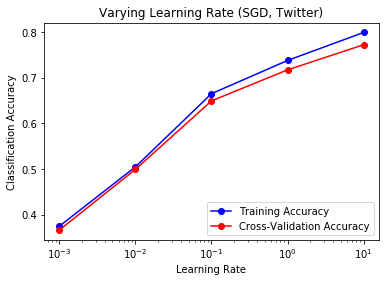

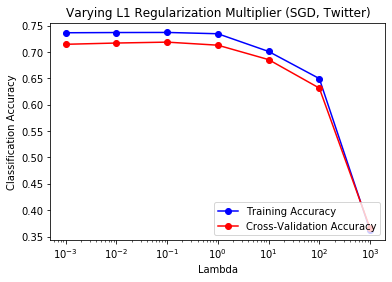

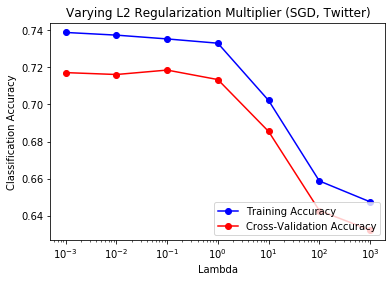

In [42]:
# Evaluation 
# Varying learning rate
# trainGDMulticlass(X, y, lr, numIters, logFreq, regularization=None, lmda=0)
lrs = np.logspace(-3,1,5)
varyLRTrainAccuracy = [] 
varyLRTestAccuracy = []
for lr in lrs: 
    # Gradient Descent Training
    ws, costs = trainGDMulticlass(textXTrain,\
        textYTrain, lr, 1000, 1000)
    # Evaluation 
    varyLRTrainAccuracy.append(logMulticlassAccuracy(textXTrain, ws, textYTrain))
    varyLRTestAccuracy.append(logMulticlassAccuracy(textXTest, ws, textYTest))

generateGraph(lrs, varyLRTrainAccuracy, varyLRTestAccuracy,\
    "Learning Rate", "Classification Accuracy", "Varying Learning Rate (SGD, Twitter)", log=True)

lmbdas = np.logspace(-3,3,7)
# Varying l1 multiplier 
varyLmbdasL1TrainAccuracy = [] 
varyLmbdasL1TestAccuracy = []
for lmbda in lmbdas: 
    # Gradient Descent Training
    ws, costs = trainGDMulticlass(textXTrain,\
        textYTrain, 1, 1000, 1000, regularization="l1", lmda=lmbda)
    # Evaluation 
    varyLmbdasL1TrainAccuracy.append(logMulticlassAccuracy(textXTrain, ws, textYTrain))
    varyLmbdasL1TestAccuracy.append(logMulticlassAccuracy(textXTest, ws, textYTest))

generateGraph(lmbdas, varyLmbdasL1TrainAccuracy, varyLmbdasL1TestAccuracy,\
    "Lambda", "Classification Accuracy", "Varying L1 Regularization Multiplier (SGD, Twitter)", log=True)

# Varying l2 multiplier 
varyLmbdasL2TrainAccuracy = [] 
varyLmbdasL2TestAccuracy = []
for lmbda in lmbdas: 
    # Gradient Descent Training
    ws, costs = trainGDMulticlass(textXTrain,\
        textYTrain, 1, 1000, 1000, regularization="l2", lmda=lmbda)
    # Evaluation 
    varyLmbdasL2TrainAccuracy.append(logMulticlassAccuracy(textXTrain, ws, textYTrain))
    varyLmbdasL2TestAccuracy.append(logMulticlassAccuracy(textXTest, ws, textYTest))

generateGraph(lmbdas, varyLmbdasL2TrainAccuracy, varyLmbdasL2TestAccuracy,\
    "Lambda", "Classification Accuracy", "Varying L2 Regularization Multiplier (SGD, Twitter)", log=True)

In [62]:
# AdaGrad Training 
ws, costs = trainAdaGradMulticlass(textXTrain,\
    textYTrain, 1, 10000, 1000, 1e-8)

# Evaluation 
print("Accuracy (Training):",
    logMulticlassAccuracy(textXTrain, ws, textYTrain))
print("Accuracy (Test):",\
    logMulticlassAccuracy(textXTest, ws, textYTest))

iter: 1000 cost: 0.30557175989696744
iter: 2000 cost: 0.305508513303024
iter: 3000 cost: 0.30548832346631216
iter: 4000 cost: 0.30547822076976505
iter: 5000 cost: 0.30547211617792575
iter: 6000 cost: 0.3054680177062809
iter: 7000 cost: 0.3054650719717706
iter: 8000 cost: 0.30546285056260736
iter: 9000 cost: 0.3054611143759742
Accuracy (Training): 0.8050717213114754
Accuracy (Test): 0.7708333333333334


C:\Users\ychen\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
C:\Users\ychen\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


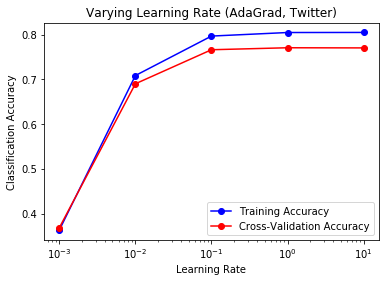

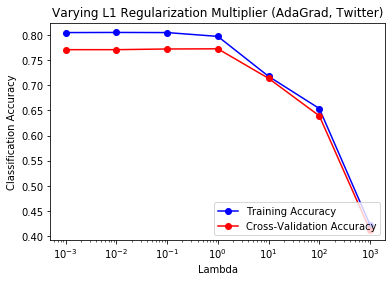

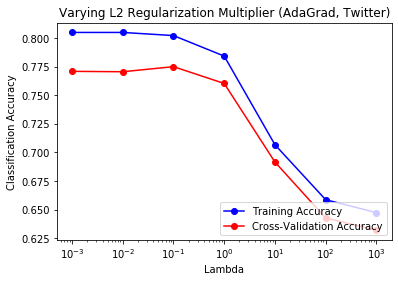

In [44]:
# Evaluation 
# Varying learning rate
lrs = np.logspace(-3,1,5)
varyLRTrainAccuracy = [] 
varyLRTestAccuracy = []
for lr in lrs: 
    # AdaGrad
    ws, costs = trainAdaGradMulticlass(textXTrain,\
        textYTrain, lr, 1000, 1000, 1e-8)
    # Evaluation 
    varyLRTrainAccuracy.append(logMulticlassAccuracy(textXTrain, ws, textYTrain))
    varyLRTestAccuracy.append(logMulticlassAccuracy(textXTest, ws, textYTest))

generateGraph(lrs, varyLRTrainAccuracy, varyLRTestAccuracy,\
    "Learning Rate", "Classification Accuracy", "Varying Learning Rate (AdaGrad, Twitter)", log=True)

lmbdas = np.logspace(-3,3,7)
# Varying l1 multiplier 
varyLmbdasL1TrainAccuracy = [] 
varyLmbdasL1TestAccuracy = []
for lmbda in lmbdas: 
    # AdaGrad
    ws, costs = trainAdaGradMulticlass(textXTrain,\
        textYTrain, 1, 1000, 1000, 1e-8, regularization="l1", lmda=lmbda)
    # Evaluation 
    varyLmbdasL1TrainAccuracy.append(logMulticlassAccuracy(textXTrain, ws, textYTrain))
    varyLmbdasL1TestAccuracy.append(logMulticlassAccuracy(textXTest, ws, textYTest))

generateGraph(lmbdas, varyLmbdasL1TrainAccuracy, varyLmbdasL1TestAccuracy,\
    "Lambda", "Classification Accuracy", "Varying L1 Regularization Multiplier (AdaGrad, Twitter)", log=True)

# Varying l2 multiplier 
varyLmbdasL2TrainAccuracy = [] 
varyLmbdasL2TestAccuracy = []
for lmbda in lmbdas: 
    # AdaGrad
    ws, costs = trainAdaGradMulticlass(textXTrain,\
        textYTrain, 1, 1000, 1000, 1e-8, regularization="l2", lmda=lmbda)
    # Evaluation 
    varyLmbdasL2TrainAccuracy.append(logMulticlassAccuracy(textXTrain, ws, textYTrain))
    varyLmbdasL2TestAccuracy.append(logMulticlassAccuracy(textXTest, ws, textYTest))

generateGraph(lmbdas, varyLmbdasL2TrainAccuracy, varyLmbdasL2TestAccuracy,\
    "Lambda", "Classification Accuracy", "Varying L2 Regularization Multiplier (AdaGrad, Twitter)", log=True)

In [59]:
# Learning curve comparison with ideal parameters 
dataPercs = np.linspace(0.2,1.0,5)

GDTrainAccDigit = []
GDTestAccDigit = []
GDTrainAccText = []
GDTestAccText = []

AdaGradTrainAccDigit = []
AdaGradTestAccDigit = []
AdaGradTrainAccText = []
AdaGradTestAccText = []

for dataPerc in dataPercs: 
    textXNumExamples = int(dataPerc * textXTrain.shape[0])
    digXNumExamples = int(dataPerc * digXTrain.shape[0])
    
    # Gradient Descent 
    ws, costs = trainGDMulticlass(digXTrain[:digXNumExamples],\
        digYTrain[:digXNumExamples], 1, 1000, 1000, regularization='l2', lmda=0.1)
    GDTrainAccDigit.append(logMulticlassAccuracy(digXTrain[:digXNumExamples],\
        ws, digYTrain[:digXNumExamples]))
    GDTestAccDigit.append(logMulticlassAccuracy(digXTest, ws, digYTest))
    
    ws, costs = trainGDMulticlass(textXTrain[:textXNumExamples],\
        textYTrain[:textXNumExamples], 1, 1000, 1000, regularization='l2', lmda=0.1)
    GDTrainAccText.append(logMulticlassAccuracy(textXTrain[:textXNumExamples],\
        ws, textYTrain[:textXNumExamples]))
    GDTestAccText.append(logMulticlassAccuracy(textXTest, ws, textYTest))
    
    # Gradient Descent 
    ws, costs = trainAdaGradMulticlass(digXTrain[:digXNumExamples],\
        digYTrain[:digXNumExamples], 1, 1000, 1000, 1e-8, regularization='l2', lmda=0.1)
    AdaGradTrainAccDigit.append(logMulticlassAccuracy(digXTrain[:digXNumExamples],\
        ws, digYTrain[:digXNumExamples]))
    AdaGradTestAccDigit.append(logMulticlassAccuracy(digXTest, ws, digYTest))
    
    ws, costs = trainAdaGradMulticlass(textXTrain[:textXNumExamples],\
        textYTrain[:textXNumExamples], 1, 1000, 1000, 1e-8, regularization='l2', lmda=0.1)
    AdaGradTrainAccText.append(logMulticlassAccuracy(textXTrain[:textXNumExamples],\
        ws, textYTrain[:textXNumExamples]))
    AdaGradTestAccText.append(logMulticlassAccuracy(textXTest, ws, textYTest))

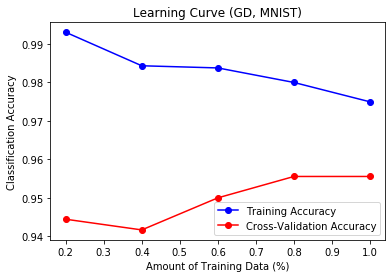

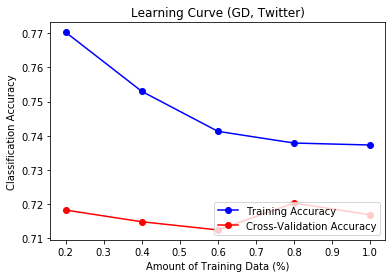

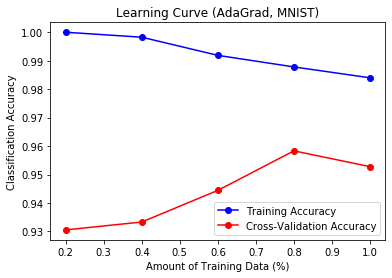

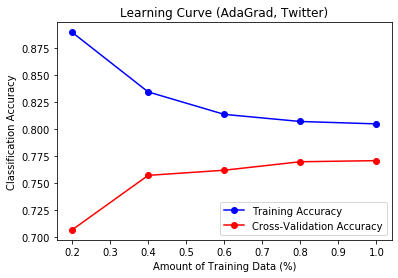

In [58]:
generateGraph(dataPercs, GDTrainAccDigit, GDTestAccDigit,\
    "Amount of Training Data (%)", "Classification Accuracy", "Learning Curve (GD, MNIST)")
generateGraph(dataPercs, GDTrainAccText, GDTestAccText,\
    "Amount of Training Data (%)", "Classification Accuracy", "Learning Curve (GD, Twitter)")
generateGraph(dataPercs, AdaGradTrainAccDigit, AdaGradTestAccDigit,\
    "Amount of Training Data (%)", "Classification Accuracy", "Learning Curve (AdaGrad, MNIST)")
generateGraph(dataPercs, AdaGradTrainAccText, AdaGradTestAccText,\
    "Amount of Training Data (%)", "Classification Accuracy", "Learning Curve (AdaGrad, Twitter)")

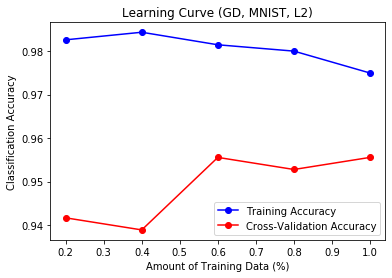

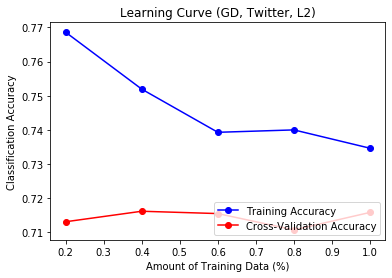

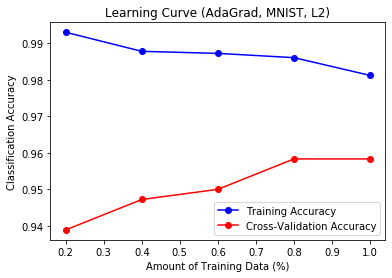

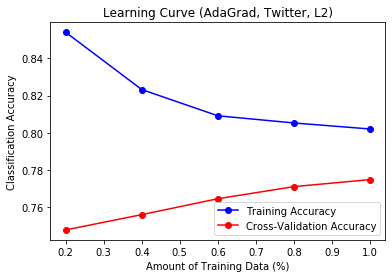

In [60]:
generateGraph(dataPercs, GDTrainAccDigit, GDTestAccDigit,\
    "Amount of Training Data (%)", "Classification Accuracy", "Learning Curve (GD, MNIST, L2)")
generateGraph(dataPercs, GDTrainAccText, GDTestAccText,\
    "Amount of Training Data (%)", "Classification Accuracy", "Learning Curve (GD, Twitter, L2)")
generateGraph(dataPercs, AdaGradTrainAccDigit, AdaGradTestAccDigit,\
    "Amount of Training Data (%)", "Classification Accuracy", "Learning Curve (AdaGrad, MNIST, L2)")
generateGraph(dataPercs, AdaGradTrainAccText, AdaGradTestAccText,\
    "Amount of Training Data (%)", "Classification Accuracy", "Learning Curve (AdaGrad, Twitter, L2)")

In [65]:
# Gradient Descent Training
ws, costs = trainGDMulticlass(textXTrain, textYTrain, 1, 1000, 50)
# Evaluation 
print("Accuracy (Training):",
    logMulticlassAccuracy(textXTrain, ws, textYTrain))
print("Accuracy (Test):",\
    logMulticlassAccuracy(textXTest, ws, textYTest))

# AdaGrad Training 
ws, costs = trainAdaGradMulticlass(textXTrain,\
    textYTrain, 1, 1000, 50, 1e-8)
# Evaluation 
print("Accuracy (Training):",
    logMulticlassAccuracy(textXTrain, ws, textYTrain))
print("Accuracy (Test):",\
    logMulticlassAccuracy(textXTest, ws, textYTest))

iter: 0 cost: 1.2167503837133653
iter: 50 cost: 0.7469404013759586
iter: 100 cost: 0.5898678408739083
iter: 150 cost: 0.5306727455619095
iter: 200 cost: 0.5014434028523618
iter: 250 cost: 0.48349827172914955
iter: 300 cost: 0.4706817629014229
iter: 350 cost: 0.4605977371386824
iter: 400 cost: 0.45217875943771757
iter: 450 cost: 0.4448910311427241
iter: 500 cost: 0.43843843135629434
iter: 550 cost: 0.43264051116188557
iter: 600 cost: 0.4273778063416926
iter: 650 cost: 0.4225655106222634
iter: 700 cost: 0.4181399683775213
iter: 750 cost: 0.4140513182743204
iter: 800 cost: 0.41025924701738165
iter: 850 cost: 0.40673039367641556
iter: 900 cost: 0.403436672318683
iter: 950 cost: 0.4003541304591029
Accuracy (Training): 0.7371926229508197
Accuracy (Test): 0.7172131147540983
iter: 0 cost: 1.2731456431576256
iter: 50 cost: 0.31205486914481223
iter: 100 cost: 0.3079421623220794
iter: 150 cost: 0.30680585518786596
iter: 200 cost: 0.30633357655712434
iter: 250 cost: 0.3060912309595301
iter: 300 co